In [2]:
%load_ext autoreload
%autoreload 2

In [108]:
import sys
sys.path.append("..")

from faigen.data import sequence
from faigen.data.sequence import regex_filter, count_filter
from functools import partial
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster,distance  
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import plotly.plotly as py
import plotly.graph_objs as go
from mpl_toolkits.mplot3d import Axes3D
import glob

## Load embdding

In [139]:

word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190612-1611-k10to10-100d-10c-4870Mbp-sliding-kPR.w2v')

In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set(color_codes=True)
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn import manifold,neighbors
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, fcluster,distance  
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import SeqIO
from Bio.Align import MultipleSeqAlignment
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio import Phylo

In [139]:
word_vectors = Word2Vec.load_word2vec_format('/data/genomes/embeddings/dna2vec-20190612-1611-k10to10-100d-10c-4870Mbp-sliding-kPR.w2v')

In [189]:
FASTA = '/home/serge/deepcelllineage/mitolin/data/gen/nguyen_nc_2018/20190702-fastas-on-hpc/1739/20lines'

filters=[]
data = sequence.Dna2VecList.from_folder(FASTA,filters=filters,n_cpus=7,emb=word_vectors, recurse=True)
processors = [
    sequence.GSFileProcessor(),
    sequence.GSTokenizeProcessor(tokenizer=sequence.GSTokenizer(ngram=10, skip=-7, n_cpus=7)),
    sequence.Dna2VecProcessor(emb=word_vectors, agg=partial(np.sum, axis=0))]# agg=partial(np.mean, axis=0))]
    
for p in processors:
    print("\n", type(p))
    %time p.process(data)

files = [fn.split("/")[-1] for fn in data.files]
labels = [f.split("_")[0] for f in files]; labels

  0%|          | 0/1 [00:00<?, ?it/s]


 <class 'faigen.data.sequence.GSFileProcessor'>
CPU times: user 9.78 ms, sys: 0 ns, total: 9.78 ms
Wall time: 9.26 ms

 <class 'faigen.data.sequence.GSTokenizeProcessor'>


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

CPU times: user 10.1 ms, sys: 217 ms, total: 227 ms
Wall time: 264 ms

 <class 'faigen.data.sequence.Dna2VecProcessor'>


CPU times: user 11.5 s, sys: 2.75 s, total: 14.2 s
Wall time: 19 s


['A04', 'A01', 'A07', 'A09', 'A06', 'A10', 'A12', 'A05', 'A03']

In [190]:
tsne = manifold.TSNE(n_components=3,init='pca', perplexity=4, metric="cosine",random_state=0)
%time X3 = tsne.fit_transform(X)
X3_df = pd.DataFrame(data=X3, columns=["pc1",'pc2',"pc3"], index=labels)

CPU times: user 360 ms, sys: 275 ms, total: 635 ms
Wall time: 158 ms


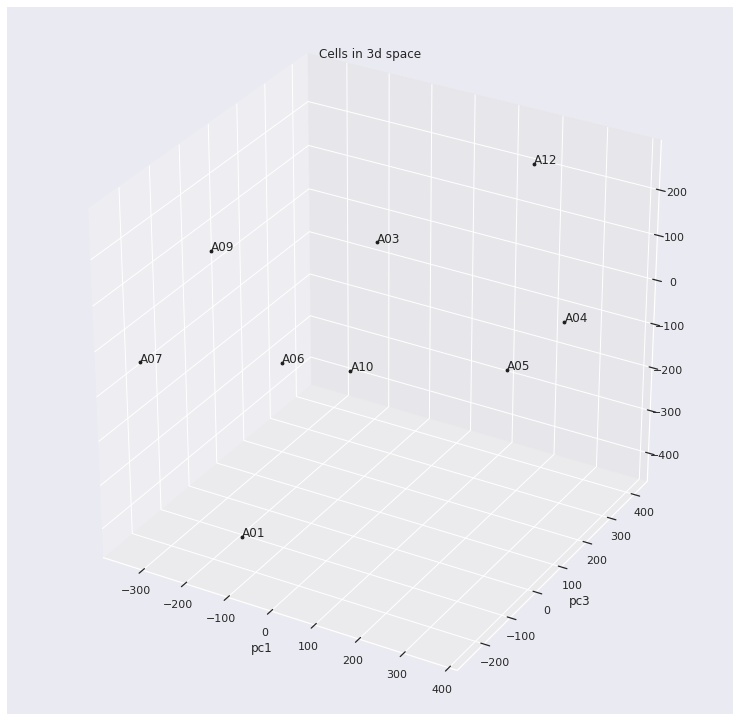

In [191]:
fig = plt.figure(figsize=(13,13))
ax = fig.add_subplot(111,projection="3d")
for cell in X3_df.index:
    ax.scatter(X3_df.loc[cell,"pc1"],X3_df.loc[cell,"pc2"],X3_df.loc[cell,"pc3"], marker="o",s=8,color='k', label = cell)
    ax.text(X3_df.loc[cell,"pc1"],X3_df.loc[cell,"pc2"],X3_df.loc[cell,"pc3"], cell, size=12)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_ylabel('pc3')
ax.set_title("Cells in 3d space")
# ax.legend(['Color represents quantity of base representation in k-mer: A - redness G - greenness C - blueness  T - transparency'])
plt.show()

CPU times: user 362 ms, sys: 260 ms, total: 621 ms
Wall time: 146 ms


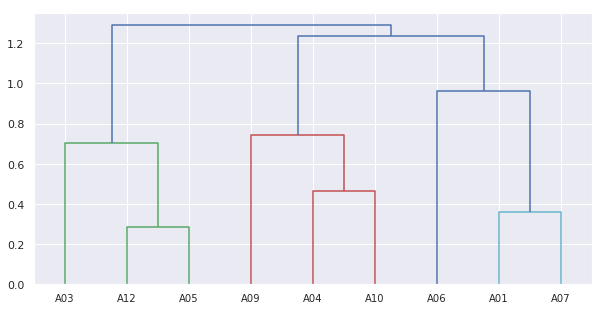

In [182]:
tsne = manifold.TSNE(n_components=3, init='pca', metric="cosine",random_state=0)
%time X3 = tsne.fit_transform(X)

linked = linkage(X3, method='average', metric="cosine")

fig=plt.figure(figsize=(10, 5)) 
ax1 = fig.add_subplot(111)

htree = dendrogram(linked,  
            ax=ax1,
            orientation='top',
            p=X3.shape[0],
            truncate_mode='lastp',
            leaf_font_size = 10,
            labels=labels,
            distance_sort='descending',
            show_contracted=True,       
            show_leaf_counts=True)


In [187]:
clusters = fcluster(linked, 1.0)